In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
data = natsorted(os.listdir("data/trained_models"))

# An h5 file is supposed to be a dictionary of labeled datasets.
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [ ]:
gm_h5["ensid"][:]

In [ ]:
def decode_and_plot(df, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    bool_df = [gene.decode() in df for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the graphs that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.any(rna_signals == 0, axis = 1))[0]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")

    print(f"TSSs w/ Signal: {[gene.decode() for gene in h5["ensid"][:][signal_index]]}")
    print(f"TSSs w/ No Signal: {[gene.decode() for gene in h5["ensid"][:][only_0s_index]]}")

    for signal in filtered_0s[0:5]:
        plt.plot(signal)
        plt.show()

In [ ]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()

for file in data:
    df = pd.read_csv(f"data/trained_models/{file}")
    if "GM12878" in file:
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

In [ ]:
neg_pred_dict = {}
neg_pred_dict["GM12878"] = []
neg_pred_dict["K562"] = []

low_error_dict = {}
low_error_dict["GM12878"] = []
low_error_dict["K562"] = []

error_threshold = 0.01
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])

    results_dict[key]["Neg Pred"] = results_dict[key]["Pred"] < 0
    neg_pred_dict[key] = list(results_dict[key][results_dict[key]["Neg Pred"]].iloc[:, 0])

    results_dict[key]["Low Error"] = results_dict[key]["Error"] < error_threshold
    low_error_dict[key] = list(results_dict[key][results_dict[key]["Low Error"]].iloc[:, 0])

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

In [ ]:
results_dict["GM12878"]

Negative Predictions

In [ ]:
# A majority of the rows with a negative prediction were rows that didn't contain a signal throughout the 2000bp window.
# The graphs for the rows that contained >= 1 non-zero value look very wonky, and didn't seem to follow any sort of pattern.
# Are these files centered around the TSS?
# There seems to be a matching ENSID between signal and no signal.
print("GM12878: ")
decode_and_plot(neg_pred_dict["GM12878"], gm_h5)

print("K562: ")
decode_and_plot(neg_pred_dict["K562"], k5_h5)

Low Errors

GM12878: 
Total Number of Matches: 526
Total Matches with >= 1 Non-Zero Value: 244
TSSs w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000169972', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000197530', 'ENSG00000197530_1', 'ENSG00000178821', 'ENSG00000067606_1', 'ENSG00000067606_3', 'ENSG00000157933', 'ENSG00000116151', 'ENSG00000116151_1', 'ENSG00000157881', 'ENSG00000157873', 'ENSG00000238164', 'ENSG00000287396', 'ENSG00000162591', 'ENSG00000078900', 'ENSG00000078900_1', 'ENSG00000235169', 'ENSG00000284668', 'ENSG00000069424', 'ENSG00000116254', 'ENSG00000285629', 'ENSG00000116251', 'ENSG00000

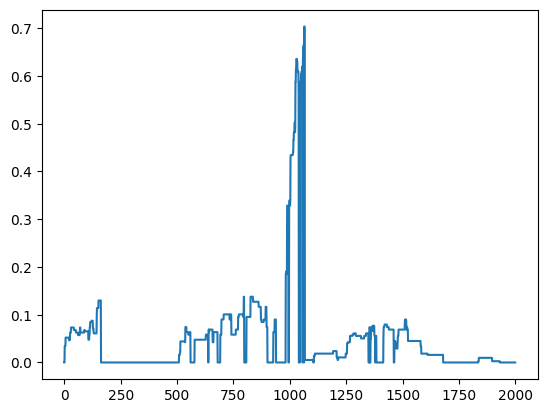

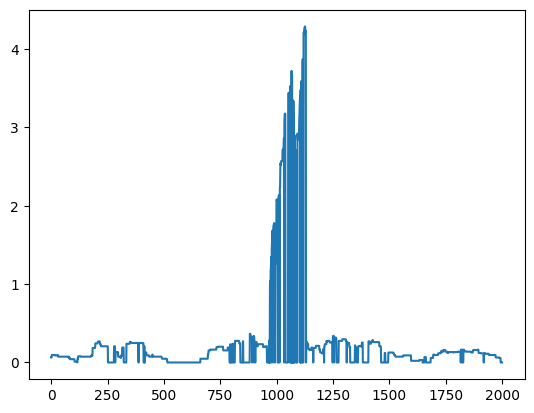

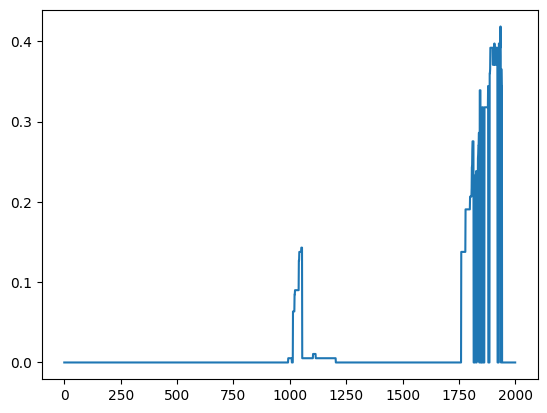

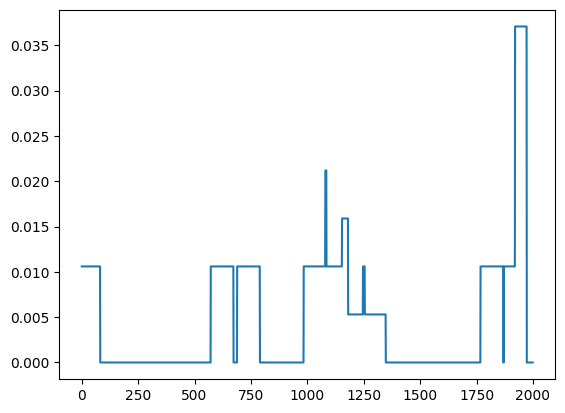

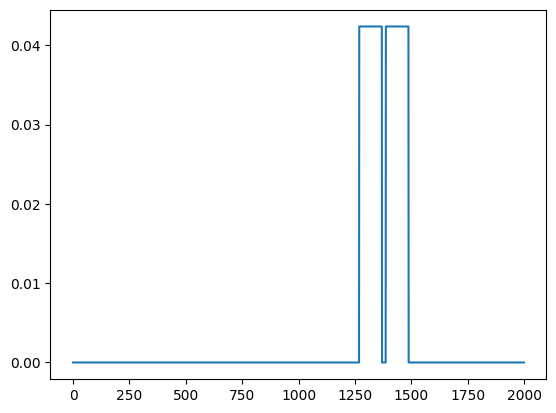

K562: 
Total Number of Matches: 565
Total Matches with >= 1 Non-Zero Value: 216
TSSs w/ Signal: ['ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188157', 'ENSG00000186827', 'ENSG00000131584', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000228594', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000157881', 'ENSG00000157873_1', 'ENSG00000157873_2', 'ENSG00000287396', 'ENSG00000130762_1', 'ENSG00000078900', 'ENSG00000235169', 'ENSG00000169598_1', 'ENSG00000198912', 'ENSG00000069424_1', 'ENSG00000116254', 'ENSG00000285629', 'ENSG00000116251',

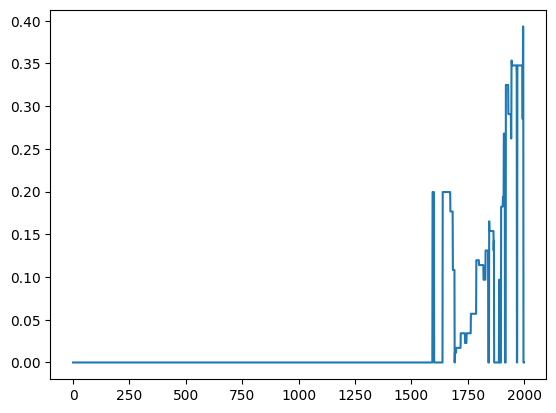

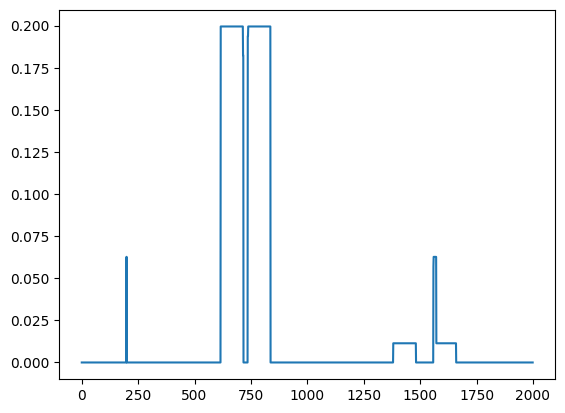

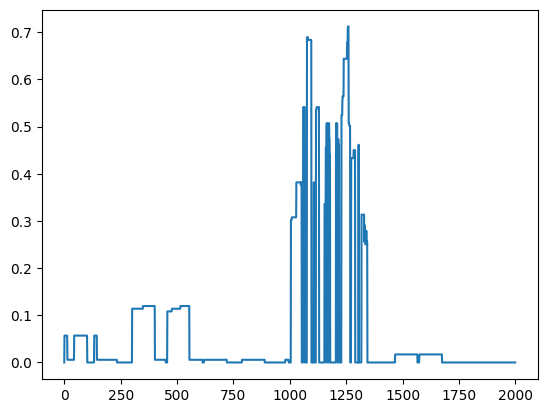

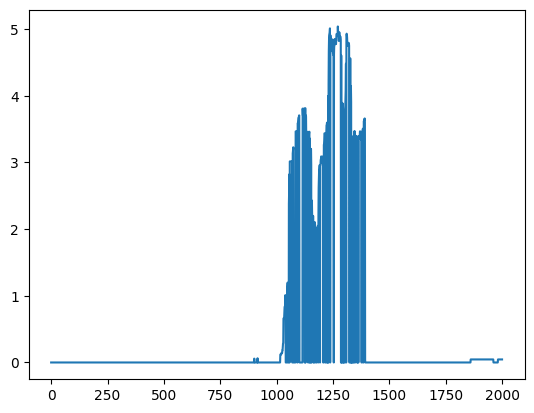

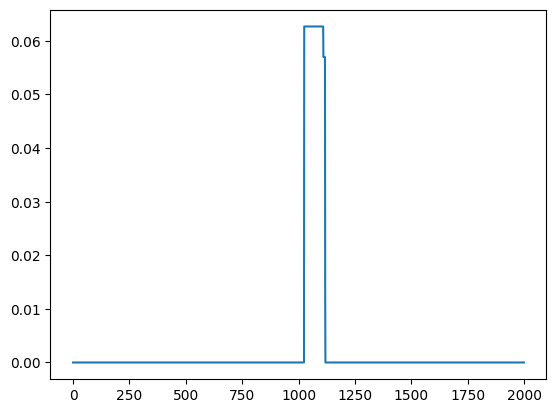

In [216]:
print("GM12878: ")
decode_and_plot(low_error_dict["GM12878"], gm_h5)

print("K562: ")
decode_and_plot(low_error_dict["K562"], k5_h5)